In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to measurement table
Measurements = Base.classes.measurement
Measurements

sqlalchemy.ext.automap.measurement

In [8]:
# Save references to station table
Station = Base.classes.station
Station

sqlalchemy.ext.automap.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
recent_date

('2017-08-23',)

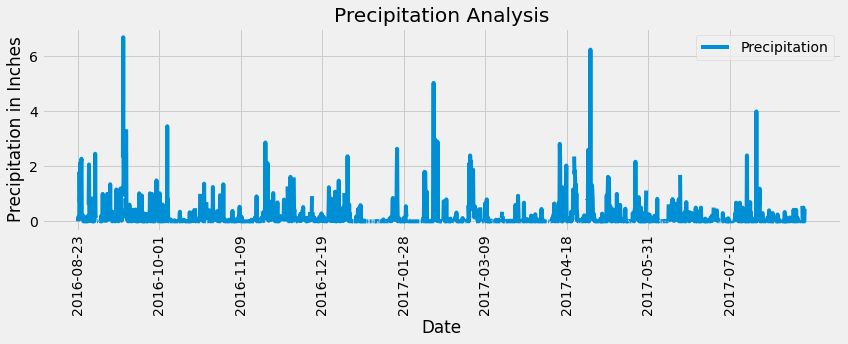

In [46]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
#print(year_ago)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurements.date, Measurements.prcp)\
                                    .filter(Measurements.date >= year_ago)\
                                    .filter(Measurements.date <= dt.date(2017,8,23))\
                                    .order_by(Measurements.date).all() 

#len(precipitation_data)

# Save the query results as a Pandas DataFrame and set the index to the date column
precp_DF = pd.DataFrame(precipitation_data, columns=["Date","Precipitation"])
precp_DF.set_index("Date",inplace=True,)
#precp_DF.head(15)

# Sort the dataframe by date
precp_DF = precp_DF.sort_values(by='Date')
precp_DF.head()

# Use Pandas Plotting with Matplotlib to plot the data
#precp_DF= precp_DF["Precipitation"].fillna(0)
x_axis_data = precp_DF.index
list_x_axis_data = [*range(len(x_axis_data))]

# Calculate xticks
x_axis_positions = np.arange(min(list_x_axis_data), max(list_x_axis_data)+1, 250)
#x_axis_positions

tick_locations = []

#assign tick locations
for x in x_axis_positions:
    tick_locations.append(x_axis_data[x])
tick_locations

#plotting the chart
precp_DF.plot(title="Precipitation Analysis", figsize=(12,5))
plt.xticks(x_axis_positions,tick_locations, rotation = "vertical")
plt.xlabel("Date")
plt.ylabel("Precipitation in Inches")

plt.legend()
plt.grid(axis='both',linewidth=1)

plt.tight_layout()
plt.savefig("images/Precipitation_Analysis.png")
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precp_DF.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to calculate the total number stations in the dataset
no_of_stations = session.query(Measurements.station).distinct().count()
no_of_stations

9

In [33]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
Most_Active_Stations = session.query(Measurements.station, Station.name, func.count(Measurements.station))\
                .filter(Measurements.station == Station.station)\
              .group_by(Measurements.station)\
              .order_by(func.count(Measurements.station).desc()).all()
        
Most_Active_Stations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [40]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temparature_data_MAS = session.query(func.min(Measurements.tobs),func.max(Measurements.tobs),\
                              func.avg(Measurements.tobs))\
                              .filter(Measurements.station == Most_Active_Stations[0][0]).all()
temparature_data_MAS
print(f"The most active station is: {Most_Active_Stations[0][0]} - {Most_Active_Stations[0][1]}")
print(f"The lowest temperature is: {temparature_data_MAS[0][0]}F")
print(f"The highest temperature is: {temparature_data_MAS[0][1]}F")
print(f"The average temperature is: {temparature_data_MAS[0][2]}F")

The most active station is: USC00519281 - WAIHEE 837.5, HI US
The lowest temperature is: 54.0F
The highest temperature is: 85.0F
The average temperature is: 71.66378066378067F


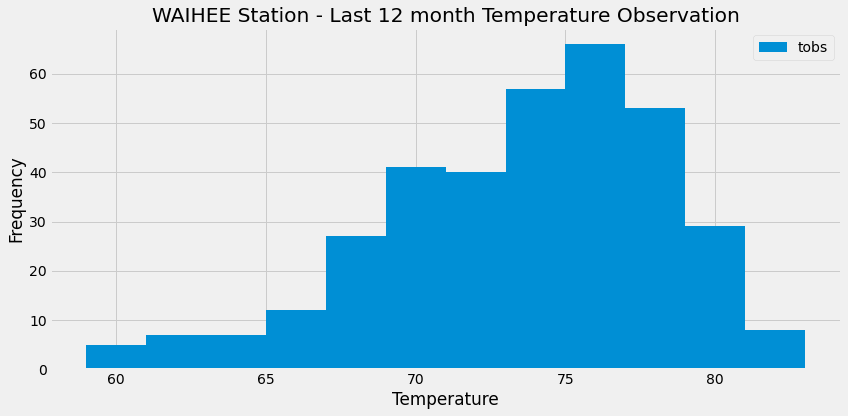

In [42]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation_12months = session.query(Measurements.tobs)\
                            .filter(Measurements.station == Most_Active_Stations[0][0])\
                            .filter(Measurements.date >= year_ago).all()
temp_observation_12months_DF = pd.DataFrame(temp_observation_12months,columns=['tobs'])

temp_observation_12months_DF.plot.hist(bins=12, rwidth=1, figsize=(12,6))
plt.title("WAIHEE Station - Last 12 month Temperature Observation")
plt.xlabel("Temperature")
plt.tight_layout()

plt.savefig("images/Station_Histogram.png")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()